# Weather in Australia - Team 7

This cell just loads all used moduls for running the notebook. Please install any package if you dont have it installed in your environment so far.

In [1]:
#disable some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
#----------------------------#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
#plots the figures in place instead of a new window
%matplotlib inline

import statistics

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from IPython.display import display, clear_output

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from abess import LinearRegression
import statsmodels.api as sm

# Dataset Overview

We chose the rain in Australia dataset from Kaggle because we thought that it could be interesting to analyze a dataset with around 145000 rows. It is also interesting that data from about 10 years of daily observations from different locations throughout Australia has been collected.

Besides several numerical attributes, also several categorical attributes are provided. The attributes of the used dataset are explained below.

<ol>
    <li> Date: The observation's date
    <li> Location: The location of the observation
    <li> MinTemp: The minimum temperature on that day (°C)
    <li> MaxTemp: The maximum temperature on that day (°C)
    <li> Rainfall: The rainfall amount measured in mm
    <li> Evaporation: The evaporation also measured in mm
    <li> Sunshine: The number of sunshine hours
    <li> WindGustDir: The strongest wind gust's direction
    <li> WindGustSpeed: The strongest wind gust's speed in km/h
    <li> WindDir9am: The wind's direction at 9 AM
    <li> WindDir3pm: The wind's direction at 3 PM
    <li> WindSpeed9am: The wind's speed (km/h) at 9 AM
    <li> WindSpeed3pm: The wind's speed (km/h) at 3 PM
    <li> Humidity9am: The humidity percentage at 9 AM
    <li> Humidity3pm: The humidity percentage at 3 PM
    <li> Pressure9am: The atmospheric pressure (hpa) at 9 AM
    <li> Pressure3pm: The atmospheric pressure (hpa) at 3 PM
    <li> Cloud9am: Fraction of obscured sky by clouds (in "oktas") at 9 AM
    <li> Cloud3pm: Same as above but at 3 PM
    <li> Temp9am: Temperature in °C at 9 AM
    <li> Temp3pm: Temperature in °C at 3 PM
    <li> RainToday: True, if it has been raining on that day, otherwise False
    <li> RainTomorrow: True, if it has been raining on the next day, otherwise False; target variable
<ol>

In [2]:
# use the weather dataset of heterogenous data and plot first 5 lines
weather = pd.read_csv('data/weatherAUS.csv')
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# overview of the created datatypes
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# Data Preparation - Adjust Date Values

In this step, the data gets adjusted, in order to fit for our analysis.
This adjustments go especially for the Date in the first place. Here the whole Date value gets split up into a new year month and day column, in order to better aggregate over the set.

In [4]:
# Convert Date to a date type and create new columns
weather['Date_converted'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')
weather['Year'] = weather['Date_converted'].dt.year
weather['Month'] = weather['Date_converted'].dt.month
weather['Day'] = weather['Date_converted'].dt.day

# Overview of missing values

In order to to a proper data cleaning and having a feeling, how many values are even missing, we analysed the amount of missing data per column. It can be seen that for some columns nearly half of the values (40 - 48%) are missing (shown in the table as well as the plot above).

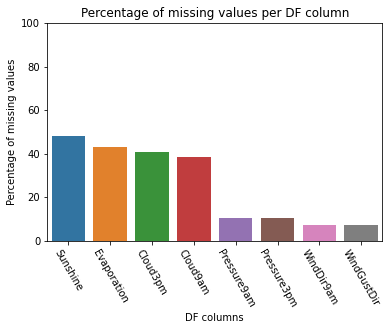

In [5]:
# Calculate percentage of null values per attribute
missing_in_percentage = weather.isnull().sum() * 100 / len(weather)
missing = pd.DataFrame({'col': weather.columns, 'missing_percent': missing_in_percentage})
missing.sort_values('missing_percent', inplace=True, ascending=False)

ax = sns.barplot(x="col", y="missing_percent", data=missing.head(8))
ax.set_ylim((0, 100))
ax.set_xticklabels(ax.get_xticklabels(), rotation=300)
ax.set_title('Percentage of missing values per DF column')
ax.set_xlabel('DF columns')
_ = ax.set_ylabel('Percentage of missing values')

# Base for missing values

## Missing values in different seasons

Now we further investigate this issue by looking at the columns sunshine, evaporation, cloud3pm and cloud9am by grouping the percentage of missing values first by season, to look whether we can see a seasonal affect. We also group the percentage of missing values by location to see if we can spot a locational affect. But as you can also see in the table below, there is no real trend, if the values tend to be not recorded in a specific season.

In [6]:
# Mapping the dates to seasons and calculate for each season and attribute the percentage of missing values.
seasons = {
   1: 'Winter',
   2: 'Spring',
   3: 'Summer',
   4: 'Autumn'
}
df_values_season = weather[['Year', 'Month', 'Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']].copy()

df_values_season['Season'] = (df_values_season['Month'] % 12 + 3) // 3
df_values_season['Season_name'] = df_values_season['Season'].map(seasons)

df_season_count_null = df_values_season[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']].isnull().groupby(df_values_season['Season_name']).sum()
df_season_count_all = df_values_season[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']].isnull().groupby(df_values_season['Season_name']).count()

df_missing_values_percent = (df_season_count_null / df_season_count_all) * 100
df_missing_values_percent['Season'] = df_missing_values_percent.index.tolist()
df_missing_values_percent.style.hide_index()

Sunshine,Evaporation,Cloud3pm,Cloud9am,Season
47.395082,42.394657,40.996689,38.537510,Autumn
48.680222,43.780054,41.022894,38.830232,Spring
48.109535,42.861420,38.639519,36.793968,Summer
47.793406,43.593759,42.648482,39.562098,Winter


## Missing values in different locations

As it can be seen, for 22 of the 49 locations no values are tracked which explains the large amount of missing data for the attributes 'Sunshine', 'Evaporation', 'Cloud3pm' and 'Cloud9am'. The reason for this is, however, unknown.

In [7]:
df_values_location = weather[['Location', 'Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']]
df_values_location_count_null = weather[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']].isnull().groupby(weather['Location']).sum()
# fillna is needed in order to get the 
df_values_location_count_all = weather[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']].isnull().groupby(weather['Location']).count()

df_missing_values_percent = (df_values_location_count_null / df_values_location_count_all) * 100
df_missing_values_percent['Location'] = df_missing_values_percent.index.tolist()
mask = (df_missing_values_percent == 100.).any(axis=1)
print(f'Untracked values based on location: {df_missing_values_percent[mask].shape[0]} of {df_missing_values_percent.shape[0]}')

Untracked values based on location: 22 of 49


# Remove missing values

Since we can not clearly 'clean' missing values in any case, because we dont have information about the geo coordinates and also no mapping of close location, we simply drop these values. Still - 112925 samples are present 

In [8]:
weather.drop(['Date','Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'],axis=1,inplace=True)

## Create artifical data for missing values in numeric attribute vectors when possible

For numeric data we set missing values for numeric attributes (given in the numerical_columns value) to the median based on the year, month and (location) when possible

For the categorical values we used the mode, imputation is based on location and current month, if we do not have data for a location than only the month was used.

In [9]:
numerical_columns = ["Pressure9am", "Pressure3pm", "Humidity3pm", "Humidity9am", "WindGustSpeed", "Temp3pm",
                     "WindSpeed3pm", "WindSpeed9am", "Temp9am", "MinTemp", "MaxTemp", "Rainfall"]

for col in numerical_columns:
    weather[col] = weather[col].fillna(weather.groupby(['Year', 'Month', 'Location'])[col].transform("mean"))
    weather[col] = weather[col].fillna(weather.groupby(['Year', 'Month'])[col].transform("mean"))

categorical_columns = ["WindDir9am", "WindGustDir", "WindDir3pm"]

for col in categorical_columns:
    weather[col] = weather[col].fillna(weather.groupby(['Year', 'Month', 'Location'])[col].transform(statistics.mode))
    weather[col] = weather[col].fillna(weather.groupby(['Year', 'Month'])[col].transform(statistics.mode))

In [10]:
weather.dropna(inplace=True)
print(f'Amount of samples without missing values in any column: {weather.shape[0]}')
weather.head()

Amount of samples without missing values in any column: 140787


,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_converted,Year,Month,Day
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,...,1007.7,1007.1,16.9,21.8,No,No,2008-12-01,2008,12,1
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,...,1010.6,1007.8,17.2,24.3,No,No,2008-12-02,2008,12,2
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,...,1007.6,1008.7,21.0,23.2,No,No,2008-12-03,2008,12,3
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,...,1017.6,1012.8,18.1,26.5,No,No,2008-12-04,2008,12,4
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,...,1010.8,1006.0,17.8,29.7,No,No,2008-12-05,2008,12,5


# Check for valid values in all remaining (numeric) columns

In the next step, # check for minimum and maximum values in numeric attributes (in our case all attributes in the frame which have the datatype of float64. Here no out of range values could be detected. 

Attribute MinTemp:
Min: -8.50, Q1: 7.60, Median 12.00, Q3: 16.80, Max: 33.90


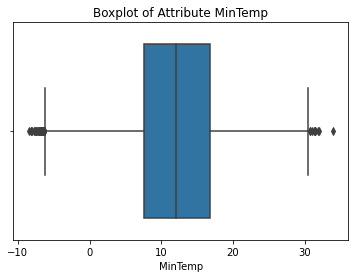

Attribute MaxTemp:
Min: -4.80, Q1: 17.90, Median 22.60, Q3: 28.20, Max: 48.10


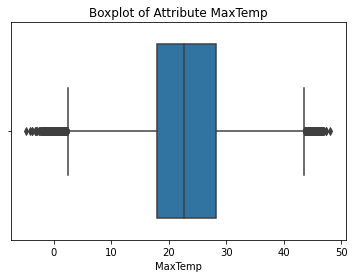

Attribute Rainfall:
Min: 0.00, Q1: 0.00, Median 0.00, Q3: 0.80, Max: 371.00


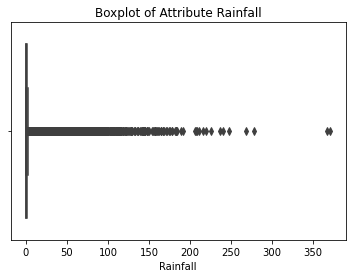

Attribute WindGustSpeed:
Min: 6.00, Q1: 31.00, Median 39.00, Q3: 46.00, Max: 135.00


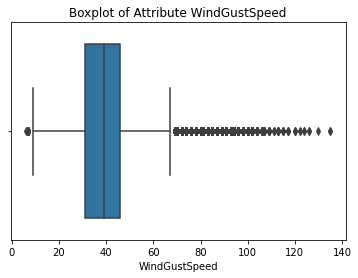

Attribute WindSpeed9am:
Min: 0.00, Q1: 7.00, Median 13.00, Q3: 19.00, Max: 130.00


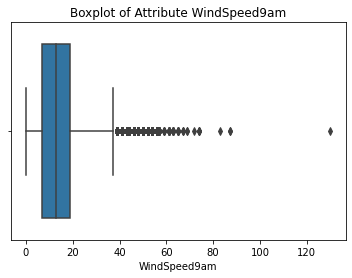

Attribute WindSpeed3pm:
Min: 0.00, Q1: 13.00, Median 19.00, Q3: 24.00, Max: 87.00


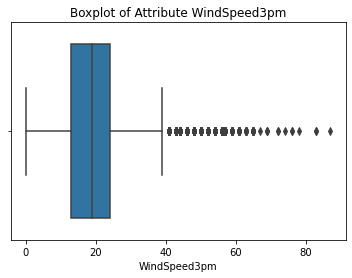

Attribute Humidity9am:
Min: 0.00, Q1: 57.00, Median 70.00, Q3: 83.00, Max: 100.00


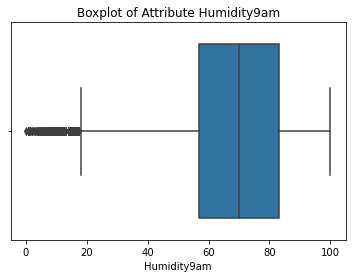

Attribute Humidity3pm:
Min: 0.00, Q1: 37.00, Median 52.00, Q3: 65.00, Max: 100.00


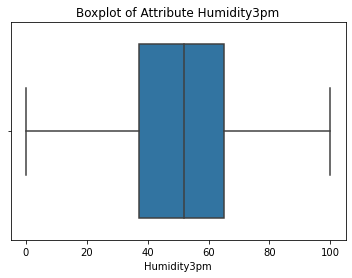

Attribute Pressure9am:
Min: 980.50, Q1: 1013.30, Median 1017.60, Q3: 1022.10, Max: 1041.00


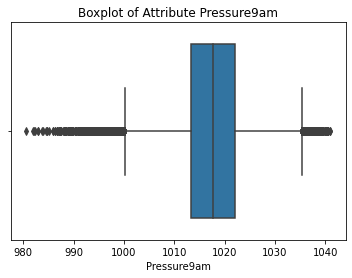

Attribute Pressure3pm:
Min: 977.10, Q1: 1010.80, Median 1015.20, Q3: 1019.68, Max: 1039.60


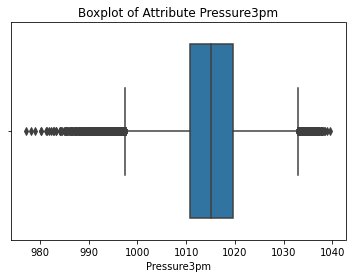

Attribute Temp9am:
Min: -7.20, Q1: 12.20, Median 16.70, Q3: 21.60, Max: 40.20


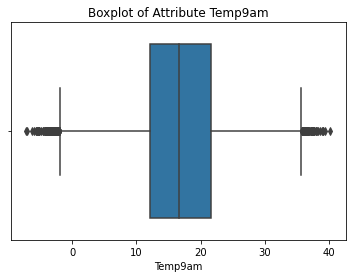

Attribute Temp3pm:
Min: -5.40, Q1: 16.60, Median 21.10, Q3: 26.40, Max: 46.70


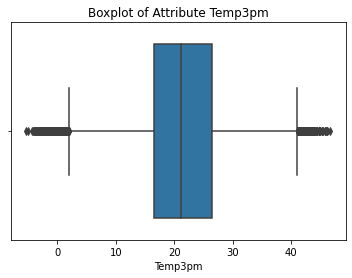

In [11]:
# check for minimum and maximum values in numeric attributes:
for col in weather.loc[:, weather.dtypes == 'float64']:
    print(f'Attribute {col}:')
    print("Min: {:.2f}, Q1: {:.2f}, Median {:.2f}, Q3: {:.2f}, Max: {:.2f}".format(weather[col].min(),weather[col].quantile(.25),weather[col].median(),weather[col].quantile(.75), weather[col].max()))
    sns.boxplot(x=weather[col])
    plt.title(f'Boxplot of Attribute {col}')
    plt.show()

# Check the distribution of RainTomorrow samples

As we can clearly see in the next cell, there are a lot more samples of NOT-raining tomorrow, as samples WITH raining tomorrow

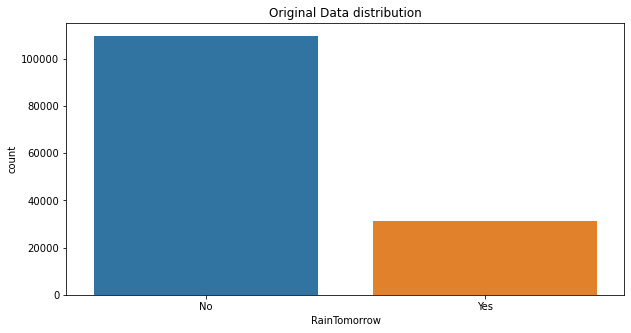

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(x="RainTomorrow", data=weather);
plt.title('Original Data distribution')
plt.show()

In [13]:
# Disproportionate sampling:
# randomly select 4 samples from each stratum
stratified = weather.groupby('RainTomorrow', group_keys=False).apply(lambda x: x.sample(31000))

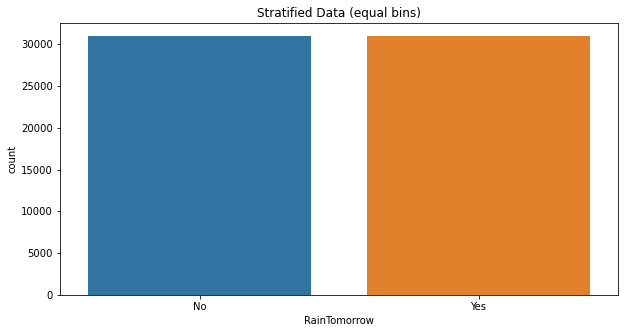

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x="RainTomorrow", data=stratified)
plt.title("Stratified Data (equal bins)")
plt.show()

# PCA to explore the underlying structure of the data

In [15]:
stratified.drop('Date_converted',axis=1,inplace=True)
for col in stratified.loc[:, stratified.dtypes == object]:
    # creating instance of labelencoder
    labelencoder = LabelEncoder()
    # Assigning numerical values and storing in another column
    stratified[f'{col}_num'] = labelencoder.fit_transform(stratified[col])
    # drop non-numeric column
    stratified.drop(col,axis=1,inplace=True)

In [16]:
stratified.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,Temp3pm,Year,Month,Day,Location_num,WindGustDir_num,WindDir9am_num,WindDir3pm_num,RainToday_num,RainTomorrow_num
121386,7.3,17.1,0.0,19.0,0.0,9.0,92.0,53.0,1031.3,1028.2,...,16.8,2010,7,19,31,11,4,8,0,0
89941,20.0,28.0,0.8,39.0,20.0,26.0,76.0,56.0,1021.0,1016.5,...,27.3,2016,8,31,8,2,0,2,0,0
29675,16.7,30.3,0.0,30.0,6.0,9.0,81.0,51.0,1015.7,1012.9,...,28.9,2016,2,11,34,0,10,2,0,0
63870,0.2,19.6,0.0,35.0,6.0,11.0,99.0,59.0,1016.3,1010.4,...,15.8,2016,8,9,35,5,14,4,0,0
20226,21.1,26.7,0.0,39.0,11.0,26.0,56.0,70.0,1003.9,1004.2,...,25.9,2015,1,15,26,8,12,10,0,0


In [17]:
n_components = 7

pca = decomposition.PCA(n_components=n_components)
pca_pos = pca.fit_transform(stratified)

stratified['pca1']= pca_pos[:, 0]
stratified['pca2']= pca_pos[:, 1]

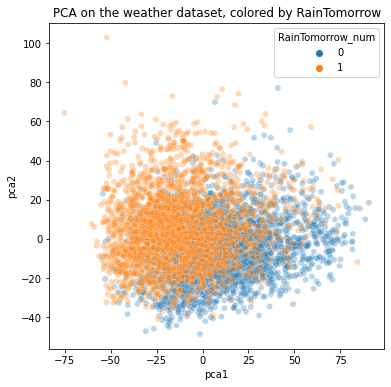

In [18]:
plt.figure(figsize=(6,6))
reducedPoints = stratified.groupby('RainTomorrow_num', group_keys=False).apply(lambda x: x.sample(2500))
sns.scatterplot(data=reducedPoints, x="pca1", y="pca2", hue="RainTomorrow_num",alpha=0.3)
plt.title('PCA on the weather dataset, colored by RainTomorrow')
plt.show()

# Decision Tree

In this section, we try to fit a Decision Tree classifier to our data. Therefore we do a GridSearch, where we try different criterions, maximum depths of the tree and splitting methods. The trained classifier also gets evaluated on 15% of the total data afterwards.

To keep the dataset clean, we removed all additional added attributes, we used in the previous section due to have more comfort. This does not change the actual data at all.

Note, that the data is also stratified like in the PCA above, so all classes are evenly distributed (standard would be to have a much higher amount of samples in the RainTomorrow=No comapred to RainTomorrow=Yes)

After creating the training and test sets, training and evaluating using a confusion matrix and accuracy as a score, we also provided an overview of the feature importance learned by the decision tree.

In [19]:
"""
Evaluates the model and returns accuracy as well as a confusion matrix. Also the time for prediction can is calculated.
@param model, sklearn model,trained model
@param x_test, np ndarray, data matrix
@param y_test, np ndarray, data vector
"""
def get_evaluation(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_mat = confusion_matrix(y_test, y_pred)
    rec_result = recall_score(y_test, y_pred, average=None, labels=[0,1])
    prec_result = precision_score(y_test, y_pred, average=None, labels=[0,1])
    

    print('\nAccuracy of Classifier on Test Image Data: ', accuracy)
    print()
    print('Recall (No Rain Tomorrow) of Classifier on Test Image Data: ', rec_result[0])
    print('Recall (Rain Tomorrow) of Classifier on Test Image Data: ', rec_result[1])
    print()
    print('Precision (No Rain Tomorrow) of Classifier on Test Image Data: ', prec_result[0])
    print('Precision (Rain Tomorrow) of Classifier on Test Image Data: ', prec_result[1])
    print()
    print('\nConfusion Matrix: \n', conf_mat)

    plt.matshow(conf_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

In [20]:
def get_ROC(model, x_test, y_test):
    """
    Calculates AUC score and plots ROC curve
    @param model, sklearn model,trained model
    @param x_test, np ndarray, data matrix
    @param y_test, np ndarray, data vector
    """
    predictions = model.predict_proba(x_test)

    print('AUC score:')
    print(roc_auc_score(y_test, predictions[:,1]))

    fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

    plt.clf()
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve with AUC: {:.3f}'.format(roc_auc_score(y_test, predictions[:,1])))
    plt.show()

In [21]:
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': range(1,20),
    'splitter': ['random', 'best']
}

"""
Trains a random forest using cross-validation and returns certain attributes of the received model including the best
parameter combination.
@param x_train, np ndarray, data matrix
@param y_train, np ndarray, data vector
@param param_grid, dict, grid holding the paramaters for search
"""
def train_dec_tree(x_train,y_train,param_grid):
    tree = DecisionTreeClassifier(random_state=55)
    model = GridSearchCV(tree,param_grid=param_grid,n_jobs = -1)
    model.fit(x_train,y_train)
    return model.best_params_,model.best_estimator_

In [22]:
# remove target value and addtional added columns
X = stratified.drop(['RainTomorrow_num','pca1','pca2'], axis=1)
y = stratified['RainTomorrow_num']
print(f'shape of data matrix: {X.shape}')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print(f'shape of train matrix: {x_train.shape}')
print(f'shape of test matrix: {x_test.shape}')
X.head()

shape of data matrix: (62000, 20)
shape of train matrix: (49600, 20)
shape of test matrix: (12400, 20)


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Year,Month,Day,Location_num,WindGustDir_num,WindDir9am_num,WindDir3pm_num,RainToday_num
121386,7.3,17.1,0.0,19.0,0.0,9.0,92.0,53.0,1031.3,1028.2,9.3,16.8,2010,7,19,31,11,4,8,0
89941,20.0,28.0,0.8,39.0,20.0,26.0,76.0,56.0,1021.0,1016.5,23.0,27.3,2016,8,31,8,2,0,2,0
29675,16.7,30.3,0.0,30.0,6.0,9.0,81.0,51.0,1015.7,1012.9,22.0,28.9,2016,2,11,34,0,10,2,0
63870,0.2,19.6,0.0,35.0,6.0,11.0,99.0,59.0,1016.3,1010.4,6.9,15.8,2016,8,9,35,5,14,4,0
20226,21.1,26.7,0.0,39.0,11.0,26.0,56.0,70.0,1003.9,1004.2,26.0,25.9,2015,1,15,26,8,12,10,0



Accuracy of Classifier on Test Image Data:  0.7725806451612903

Recall (No Rain Tomorrow) of Classifier on Test Image Data:  0.7879371190247032
Recall (Rain Tomorrow) of Classifier on Test Image Data:  0.7570548167369445

Precision (No Rain Tomorrow) of Classifier on Test Image Data:  0.7663026521060843
Precision (Rain Tomorrow) of Classifier on Test Image Data:  0.7792988313856427


Confusion Matrix: 
 [[4912 1322]
 [1498 4668]]
The best parameters are: {'criterion': 'gini', 'max_depth': 8, 'splitter': 'best'}


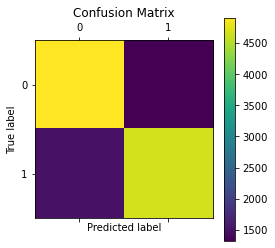

In [23]:
# train decision tree with created training set and evaluate on created target set
params_dec_tree, model_dec_tree = train_dec_tree(x_train, y_train, param_grid)
_ = get_evaluation(model_dec_tree, x_test, y_test)
print("The best parameters are: {}".format(params_dec_tree))

AUC score:
0.8494503112528567


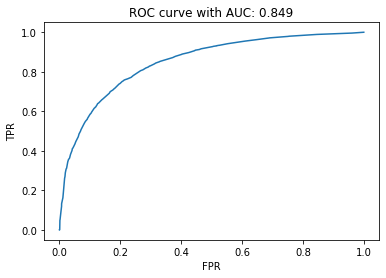

In [24]:
# print AUC score and ROC curve
get_ROC(model_dec_tree, x_test, y_test)

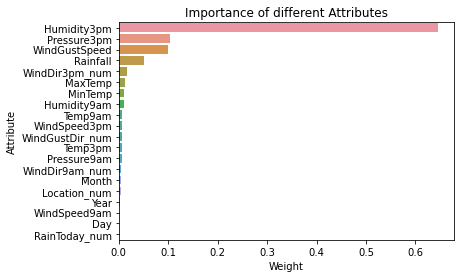

In [25]:
# create overview of feature importance, of learned decision tree
attribute_weights = pd.DataFrame({
    'Attribute' : x_train.columns,
    'Weight' : model_dec_tree.feature_importances_
}).sort_values(by='Weight', ascending=False)
plt.title('Importance of different Attributes')
sns.barplot(data = attribute_weights, x='Weight', y='Attribute');

## Random Forest

In [26]:
param_grid_forest = {
    'criterion': ['gini','entropy'],
    'max_depth': range(5,25)
}

"""
Trains a random forest using cross-validation and returns certain attributes of the received model including the best
parameter combination.
@param x_train, np ndarray, data matrix
@param y_train, np ndarray, data vector
@param param_grid, dict, grid holding the paramaters for search
"""
def train_random_forest(x_train,y_train,param_grid):
    ensemble = RandomForestClassifier(random_state=55)
    model = GridSearchCV(ensemble,param_grid=param_grid, n_jobs = -1)
    model.fit(x_train,y_train)
    return model.best_params_,model.best_estimator_


Accuracy of Classifier on Test Image Data:  0.8013709677419355

Recall (No Rain Tomorrow) of Classifier on Test Image Data:  0.8078280397818415
Recall (Rain Tomorrow) of Classifier on Test Image Data:  0.7948426856957509

Precision (No Rain Tomorrow) of Classifier on Test Image Data:  0.7992382161561656
Precision (Rain Tomorrow) of Classifier on Test Image Data:  0.8035743564518774


Confusion Matrix: 
 [[5036 1198]
 [1265 4901]]
The best parameters are: {'criterion': 'entropy', 'max_depth': 23}


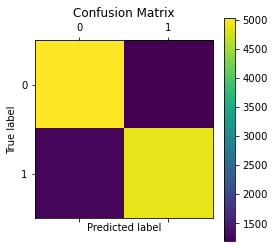

In [27]:
# train decision tree with created training set and evaluate on created target set
params_random_forest, model_random_forest = train_random_forest(x_train, y_train, param_grid_forest)
_ = get_evaluation(model_random_forest, x_test, y_test)
print("The best parameters are: {}".format(params_random_forest))

AUC score:
0.8836974910067534


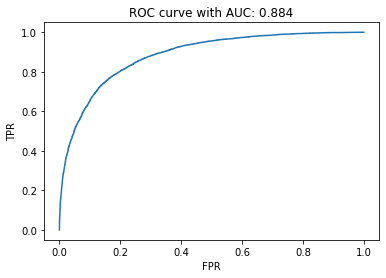

In [28]:
# print AUC score and ROC curve
get_ROC(model_random_forest, x_test, y_test)

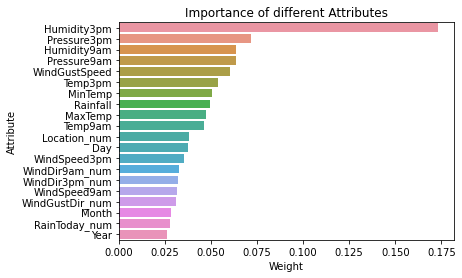

In [29]:
# create overview of feature importance, of learned decision tree
attribute_weights = pd.DataFrame({
    'Attribute' : x_train.columns,
    'Weight' : model_random_forest.feature_importances_
}).sort_values(by='Weight', ascending=False)
plt.title('Importance of different Attributes')
sns.barplot(data = attribute_weights, x='Weight', y='Attribute');

# Extreme Gradient Boosting

In [30]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


Accuracy of Classifier on Test Image Data:  0.8062903225806451

Recall (No Rain Tomorrow) of Classifier on Test Image Data:  0.8118383060635226
Recall (Rain Tomorrow) of Classifier on Test Image Data:  0.8006811547194291

Precision (No Rain Tomorrow) of Classifier on Test Image Data:  0.804610492845787
Precision (Rain Tomorrow) of Classifier on Test Image Data:  0.8080196399345335


Confusion Matrix: 
 [[5061 1173]
 [1229 4937]]


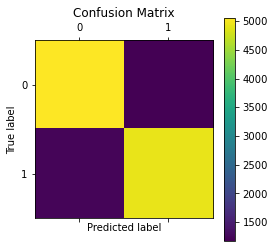

In [31]:
_ = get_evaluation(xgb, x_test, y_test)

AUC score:
0.8871751320096931


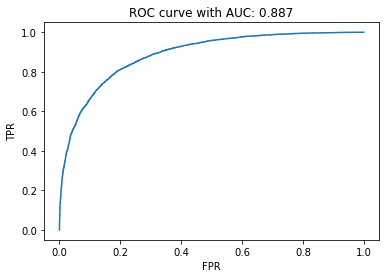

In [32]:
# print AUC score and ROC curve
get_ROC(xgb, x_test, y_test)

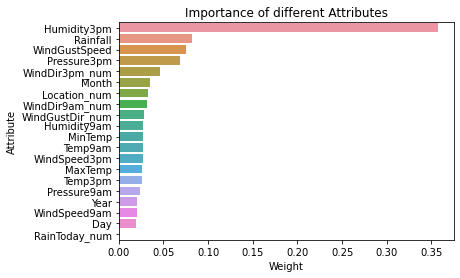

In [33]:
# create overview of feature importance, of learned decision tree
attribute_weights = pd.DataFrame({
    'Attribute' : x_train.columns,
    'Weight' : xgb.feature_importances_
}).sort_values(by='Weight', ascending=False)
plt.title('Importance of different Attributes')
sns.barplot(data = attribute_weights, x='Weight', y='Attribute');

# Regression

In this part, are going to develop an estimator for the rainfall. Since, rainfall is a continuous variable, this is obviously a regression task.

Since, this is going to be a multiple regression task, and therefore, not all variables might have a significant impact, we chose the best subset selection method
for identifying the required variables.

## Data preparation for the regression part

In [34]:
x_train_reg = x_train.loc[x_train['Rainfall'] > 0, x_train.columns != 'Rainfall'].copy()
x_test_reg = x_test.loc[x_test['Rainfall'] > 0, x_test.columns != 'Rainfall'].copy()

y_train_reg = x_train[x_train['Rainfall'] > 0]['Rainfall'].copy()
y_test_reg = x_test[x_test['Rainfall'] > 0]['Rainfall'].copy()

Now, after the data is prepared for the regression part, we now start the subset selection to retrieve.

For this we are going to the use the abess package which uses the ABESS algorithm proposed by Zhu et al. (2020).

Junxian Zhu, Canhong Wen, Jin Zhu, Heping Zhang, and Xueqin Wang. A polynomial
algorithm for best-subset selection problem.
Proceedings of the National Academy of
Sciences, 2020.
ISSN 0027-8424.
doi: 10.1073/pnas.2014241117.
URL https://www.
pnas.org/content/early/2020/12/14/2014241117.

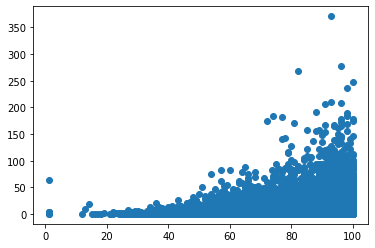

In [35]:
plt.scatter(x_train_reg['Humidity9am'], y_train_reg)

In [36]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train_reg.to_numpy(), y_train_reg.to_numpy())

LinearRegression()

In [37]:
np.nonzero(linear_regression_model.coef_)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7, 10, 12, 15, 16, 18], dtype=int64)

In [38]:
x_train_for_ols = x_train_reg.iloc[:,np.nonzero(linear_regression_model.coef_)[0]]
res = sm.OLS(y_train_reg, x_train_for_ols).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Rainfall   R-squared (uncentered):                   0.369
Model:                            OLS   Adj. R-squared (uncentered):              0.368
Method:                 Least Squares   F-statistic:                              1012.
Date:                Tue, 31 May 2022   Prob (F-statistic):                        0.00
Time:                        14:50:01   Log-Likelihood:                         -90845.
No. Observations:               22538   AIC:                                  1.817e+05
Df Residuals:                   22525   BIC:                                  1.818e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
MinTemp             0.1656      0.038      4.384      0.000       0.092       0.240
MaxTemp            -0.3488      0.068     -5.106      0.000      -0.483      -0.215
WindGustSpeed       0.1452      0.009     16.192      0.000       0.128       0.163
WindSpeed9am        0.1210      0.014      8.902      0.000       0.094       0.148
WindSpeed3pm       -0.1201      0.014     -8.767      0.000      -0.147      -0.093
Humidity9am         0.1452      0.009     16.806      0.000       0.128       0.162
Humidity3pm         0.0926      0.009     10.727      0.000       0.076       0.109
Pressure9am        -0.0284      0.001    -26.330      0.000      -0.031      -0.026
Temp3pm             0.6568      0.074      8.817      0.000       0.511       0.803
Month              -0.0854      0.030     -2.862      0.004      -0.144      -0.027
WindGustDir_num    -0.0822      0.023     -3.596      0.000      -0.127      -0.037
WindDir9am_num      0.1356      0.023      5.939      0.000       0.091       0.180
RainToday_num       8.5603      0.210     40.830      0.000       8.149       8.971
==============================================================================
Omnibus:                    26137.151   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4609433.505
Skew:                           5.934   Prob(JB):                         0.00
Kurtosis:                      72.048   Cond. No.                     2.36e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import itertools

def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [40]:
Y = y_train_reg
X = x_train_reg
k = len(X.columns)
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf

    for combo in itertools.combinations(remaining_features,1):

        RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result

        if RSS[0] < best_RSS:
            best_RSS = RSS[0]
            best_R_squared = RSS[1]
            best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)

    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [41]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

Calculating C\_p, AIC and BIC

In [42]:
#Initializing useful variables
m = len(Y)
p = k
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[RainToday_num],4.546039e+06,0.117237,1,201.721976,1.089209,1.089565,0.117197
2,"[RainToday_num, MinTemp]",4.418057e+06,0.142089,2,196.059875,1.058636,1.059348,0.142013
3,"[RainToday_num, MinTemp, Humidity9am]",4.323817e+06,0.160388,3,191.894962,1.036147,1.037215,0.160277
4,"[RainToday_num, MinTemp, Humidity9am, WindGust...",4.249877e+06,0.174746,4,188.630703,1.018522,1.019946,0.174600
5,"[RainToday_num, MinTemp, Humidity9am, WindGust...",4.236782e+06,0.177289,5,188.066112,1.015473,1.017253,0.177107
6,"[RainToday_num, MinTemp, Humidity9am, WindGust...",4.227136e+06,0.179162,6,187.654574,1.013251,1.015387,0.178944
7,"[RainToday_num, MinTemp, Humidity9am, WindGust...",4.215913e+06,0.181342,7,187.173023,1.010651,1.013143,0.181087
8,"[RainToday_num, MinTemp, Humidity9am, WindGust...",4.201898e+06,0.184063,8,186.567632,1.007382,1.010230,0.183773
9,"[RainToday_num, MinTemp, Humidity9am, WindGust...",4.195035e+06,0.185396,9,186.279569,1.005827,1.009030,0.185070
10,"[RainToday_num, MinTemp, Humidity9am, WindGust...",4.188069e+06,0.186748,10,185.986918,1.004246,1.007806,0.186387


In [43]:
df1['R_squared_adj'].idxmax()
df1['R_squared_adj'].max()

0.18954641261078775

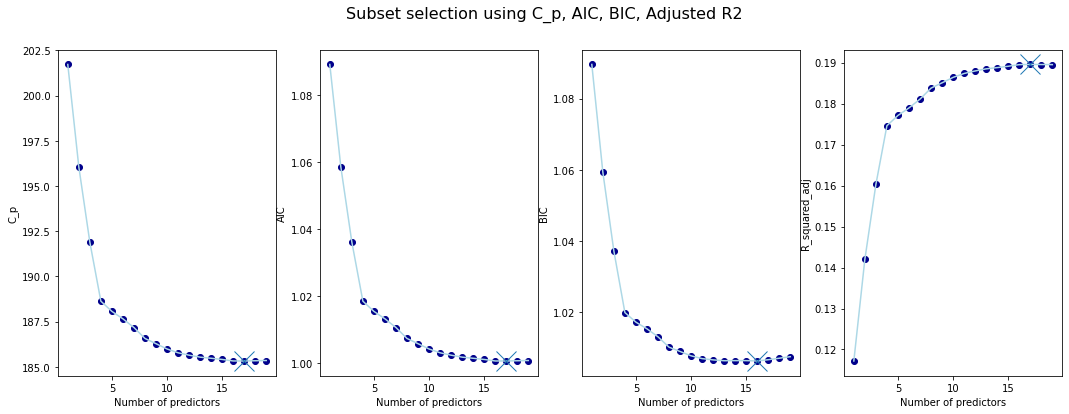

In [44]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()